# 畫出每個道歉和事件聲量＆好感

In [2]:
import csv
import datetime
import time
import os

import matplotlib.pyplot as plt
import collections
from openpyxl import load_workbook

import math
import statistics
import numpy as np
import pandas as pd

In [14]:
def get_filename_from_folder(folder_path, ext=""):
    file_name_list = []
    for file_name in os.listdir(folder_path):
        name = os.path.join(folder_path + "/"+ file_name)
        
        # get file extension
        file_ext = os.path.splitext(file_name)[1]
        # if user give ext and the file extension is not the same, pass
        if ext and file_ext != ext:
            continue
        
        # os.rename(name, os.path.join(folder_path + "/"+ file_name[1:]))  
        file_name_list.append(name)
        
    return sorted(file_name_list)

def filename_process(target, filename_list):
    
    split_file_name = [ x.split("_") for x in filename_list]
    
    for i in split_file_name:
        try:
            ytr = i[1][1:]
            types = i[3]
            start = i[4]
            end = i[5].split(".")[0]
        
            if target == ytr:
                yield ytr, types, start, end
        except:
            pass

def get_file_by_ytr_and_date(ytr, types, start, filename_list):
    file_list = []
    for fytr, ftypes, fstart, fend in filename_process(ytr, filename_list):
        if fytr == ytr and ftypes == types and fstart == start:
            name = f"./yt_/{fytr}_單主題_{ftypes}_{fstart}_{fend}.xlsx"

            file_list.append(name)
    return file_list


def string_to_datetime(s):
    return datetime.datetime.strptime(s, '%Y/%m/%d')


# opview 資料（趨勢 和 好感度）
def get_ytrs_view_and_emotion_by_startdate(ytrs: list, startdate: str, enddate: str, filename_list_op: list):
    
    ytrs_view = []
    ytrs_emotion = []
    
    for ytr in ytrs: # iter each youtuber
        # read all views data
        op_view_data = collections.OrderedDict()
        for date in DATE:
            for filename in get_file_by_ytr_and_date(ytr, '趨勢', date, filename_list_op):
                wb = load_workbook(filename=filename)
                # op_view_data['name'] = ytr
                opview_wb = wb['日趨勢']
                for i in range(2, opview_wb.max_row+1):
                    day = opview_wb.cell(column=1, row=i).value
                    qty = opview_wb.cell(column=2, row=i).value
                    
                    if day >= startdate and day <= enddate:
                        op_view_data[day] = qty
        ytrs_view.append(op_view_data)

        # read all good bad data
        op_view_emotion = collections.OrderedDict(
            {'good': collections.OrderedDict(), 'bad': collections.OrderedDict()})
        for date in DATE:
            for filename in get_file_by_ytr_and_date(ytr, '情緒', date, filename_list_op):
                # opview 資料（情緒）
                wb = load_workbook(filename=filename)
                opview_wb = wb['日情緒趨勢']
                for i in range(2, opview_wb.max_row+1):

                    day = opview_wb.cell(column=1, row=i).value
                    good = opview_wb.cell(column=2, row=i).value
                    bad = opview_wb.cell(column=3, row=i).value
                    total = opview_wb.cell(column=4, row=i).value
                    if day >= startdate and day <= enddate:
                        op_view_emotion["good"][day] = good
                        op_view_emotion["bad"][day] = bad
        ytrs_emotion.append(op_view_emotion)

    return ytrs_view ,ytrs_emotion


def generate_ytr_name_list(filename="Youtuber名單 - 道歉.csv"):
    ytr_list = []
    with open(filename, 'r') as f:
        rows = csv.reader(f)
        for row in rows:
            if row[1] == "":
                pass
            if row[1] == "頻道(官方帳號)":
                continue
            ytr_name = []
            ytr_name.append(row[1].replace(
                "/", " ").replace("   ", " ").split("\n")[0])

            ytr_name.extend(row[3].replace("、", "\n").split("\n"))
            ytr_list.append(list(dict.fromkeys(ytr_name)))
    return ytr_list
                    

# plot views and good/bad emotions
def plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs, stepsize=1, figsize=(19, 4)):
    for view, emotion, name in zip(ytrs_view, ytrs_emotion, ytrs):
        print(name)
        fig, ax1 = plt.subplots(figsize=figsize)
        ax1.plot(view.values(), figure=fig,
                 linewidth=1, c='black', label="opview")
        ax1.plot(emotion["good"].values(), figure=fig,
                 linewidth=1, c='g', label="good")
        ax1.plot(emotion["bad"].values(), figure=fig,
                 linewidth=1, c='r', label="bad")
        plt.xticks(range(0, len(list(view.keys())), stepsize),
                   list(view.keys())[::stepsize], rotation=20)
        ax1.legend()
        plt.show()


# plot vies and good/bad emotions and event/sorry mark
def plot_view_and_emotion_and_event_sorry_mark(ytrs_view, ytrs_emotion, ytrs, stepsize=1, figsize=(19, 4)):
    for view, emotion, name in zip(ytrs_view, ytrs_emotion, ytrs):
        print(name)
        fig, ax1 = plt.subplots(figsize=figsize)
        ax1.plot(view.values(), figure=fig,
                 linewidth=1, c='black', label="opview")
        ax1.plot(emotion["good"].values(), figure=fig,
                 linewidth=1, c='g', label="good")
        ax1.plot(emotion["bad"].values(), figure=fig,
                 linewidth=1, c='r', label="bad")
        plt.xticks(range(0, len(list(view.keys())), stepsize),
                   list(view.keys())[::stepsize], rotation=20)
        ax1.legend()
        plt.show()


In [37]:
filename_list_op = get_filename_from_folder("./yt_", ".xlsx")
ytrs_opview = pd.read_csv("../ytr_data.csv", index_col=0)['opview'].to_list() 
ytrs_crawl = pd.read_csv("../ytr_data.csv", index_col=0)['ytr_crawl'].to_list()
sorry_event_df = pd.read_csv("../sorry_event_match.csv")

sorry_event_df.columns


Index(['Youtuber', '道歉日', 'YTR 類別', '犯錯的類別', 'sub', 'g/b', '前二後二情緒變化量', '期間'], dtype='object')

In [38]:
DATA_FOLDER_PATH = "/Users/bobo/OneDrive - 台灣微軟/0. bobo/Codes/crawlers/data/"
DATE = ["20191201", "20201201"]
STARTDATE = "2019/10/12"
# STARTDATE = "20200201"
ENDDATE = "2022/11/16"
ytrs_view, ytrs_emotion = get_ytrs_view_and_emotion_by_startdate(
    ytrs_opview, STARTDATE, ENDDATE, filename_list_op)


/Users/bobo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [55]:
min(ytrs_view[0].keys())

'2019/12/01'

In [64]:
stepsize = 100
for ytr_op, ytr_crawl, view, emotion in zip(ytrs_opview, ytrs_crawl, ytrs_view, ytrs_emotion):

    # 從sorry event對照表中，抓出某ytr的所有事件
    ytr_sorry_event = sorry_event_df[sorry_event_df["Youtuber"] == ytr_crawl]

    # 如果沒有事件，跳過
    if ytr_sorry_event.shape[0] <= 0:
        continue

    # fig, ax1 = plt.subplots(figsize=(19,2))
    # ax1.plot(view.values(), figure=fig,
    #          linewidth=1, c='black', label="opview")
    # ax1.plot(emotion["good"].values(), figure=fig,
    #          linewidth=1, c='g', label="good")
    # ax1.plot(emotion["bad"].values(), figure=fig,
    #          linewidth=1, c='r', label="bad")
    # plt.xticks(range(0, len(list(view.keys())), stepsize),
    #            list(view.keys())[::stepsize], rotation=20)
    # ax1.legend()
    


    # 加上事件
    max_x = max(view.values())
    
    for idx, row in ytr_sorry_event.iterrows():
        sorryday = string_to_datetime( row['道歉日'])
        eventday = string_to_datetime(row['期間'])
        firstday = string_to_datetime('2019/12/01')

        sorry_duration = (sorryday - firstday).days
        event_duration = (eventday - firstday).days
        print(f"{ytr_crawl}   {sorry_duration-event_duration}")
    

    



Dinter   5
Joeman   42
NanaQ   16
Toyz   1
heyitsmindy   3
一隻阿圓 I am CIRCLE   4
上班不要看 NSFW   2
丹妮婊姐星球   3
丹妮婊姐星球   6
Jinnytty 企鵝妹 윰찌   1
Stand up, Brian! 博恩站起來！   7
WACKYBOYS 反骨男孩   4
呱吉   10
鼻地大師國動-張葦航   47
大蛇丸   8
大麻煩   3
愛莉莎莎 Alisasa   6
愛莉莎莎 Alisasa   1
愛莉莎莎 Alisasa   1
放火 Louis   1
木曜4超玩   3
木曜4超玩   13
滴妹   18
統神大戲院   37
統神大戲院   1
綠眼鏡Punk   4
蔡桃貴 蔡阿嘎二伯's Family   1
見習網美小吳   5
見習網美小吳   3
許藍方博士 Dr. Gracie   9
谷阿莫   10
鍾明軒   1
阿滴英文   16
黃氏兄弟   4
龍龍LungLung   9


Dinter


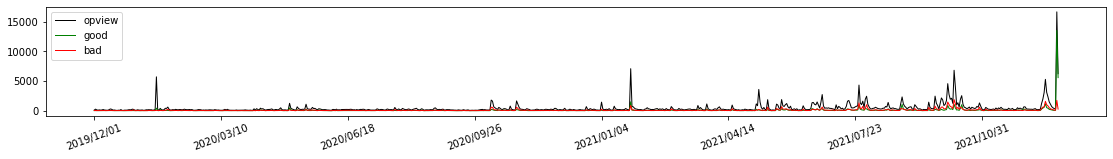

Dr.Ivan


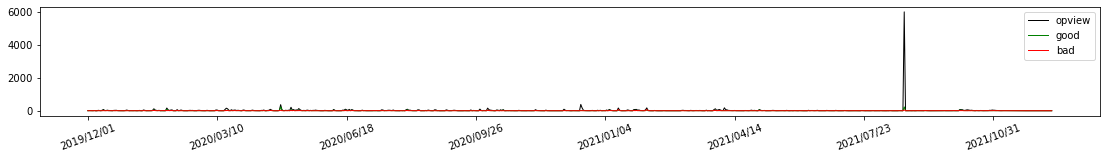

Hello Catie


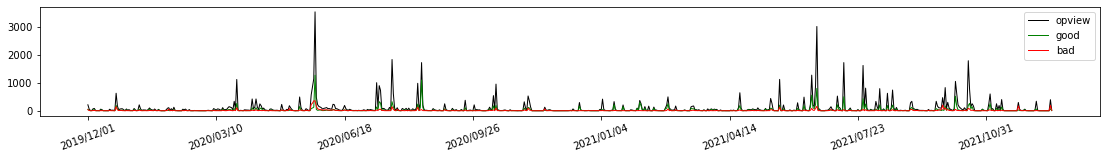

HowFun


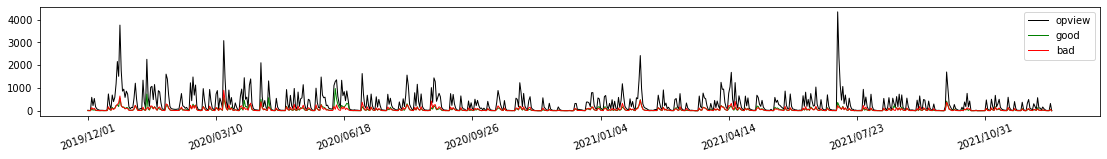

Joeman


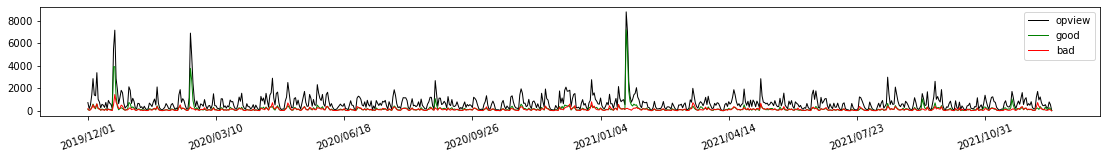

NanaQ


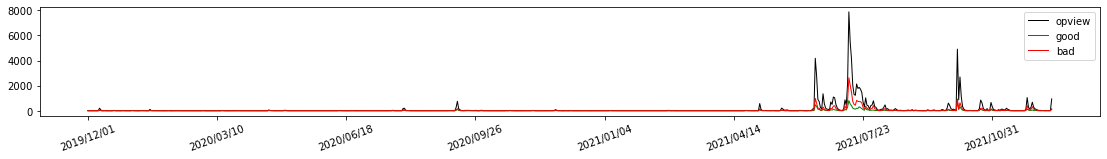

Pan Piano


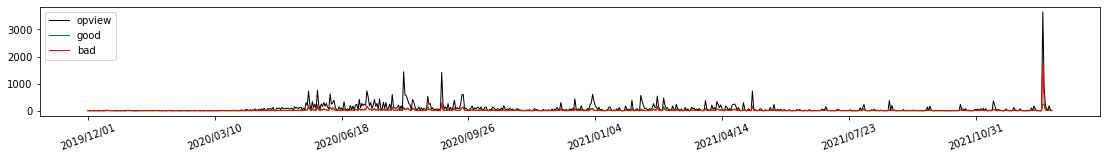

Toyz


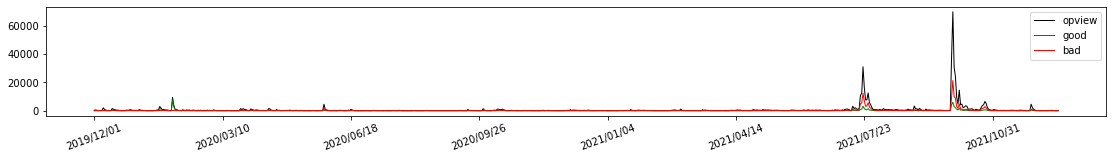

heyitsmindy


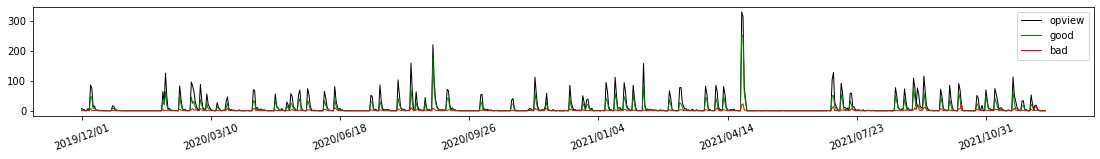

一隻阿圓


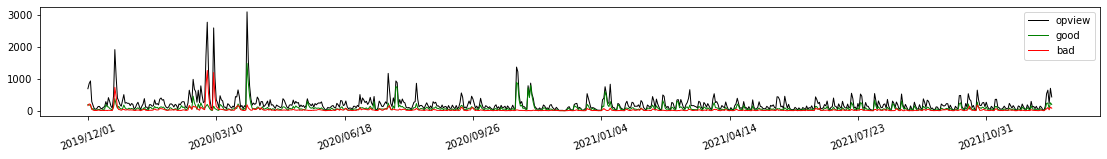

上班不要看


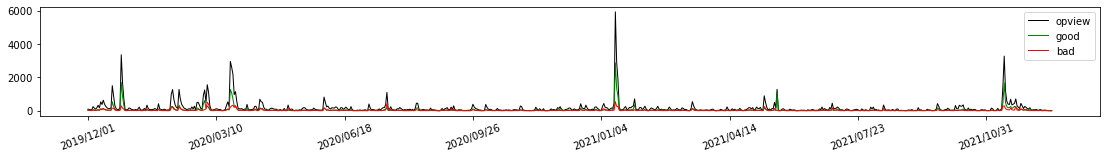

丹妮婊姐


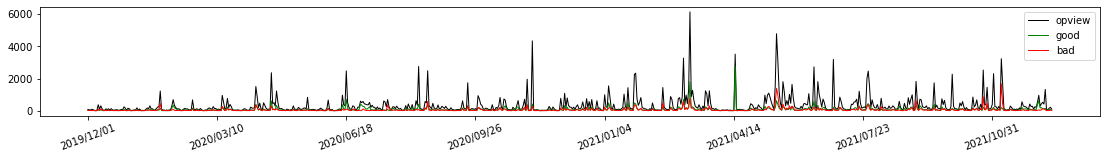

企鵝妹


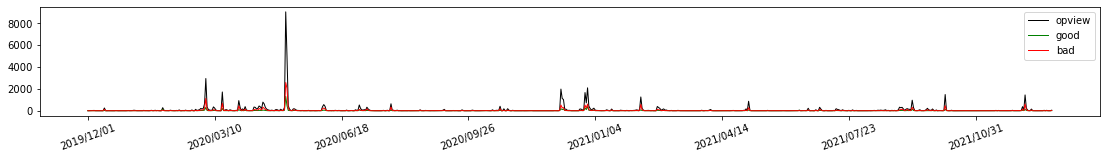

博恩


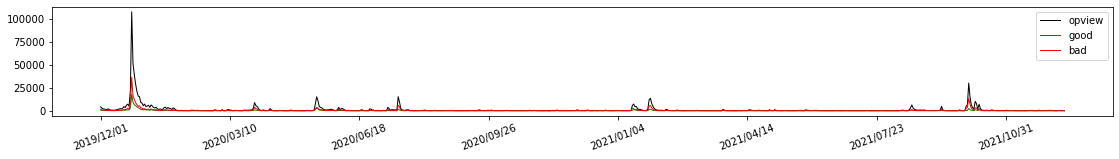

反骨男孩


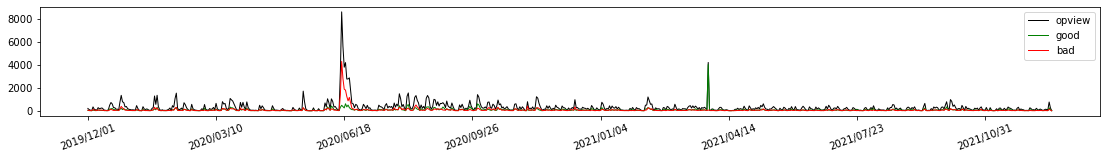

古娃娃


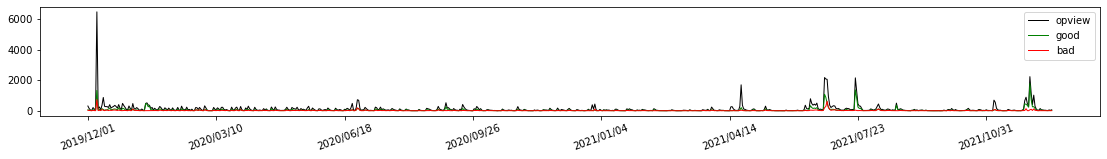

呱吉


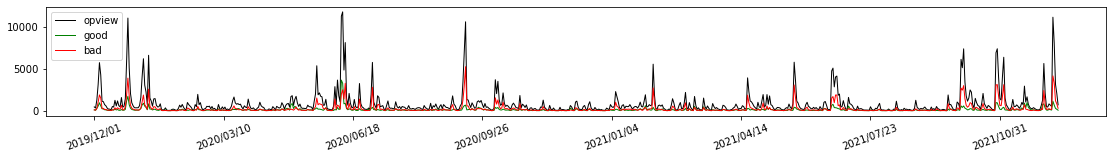

國動


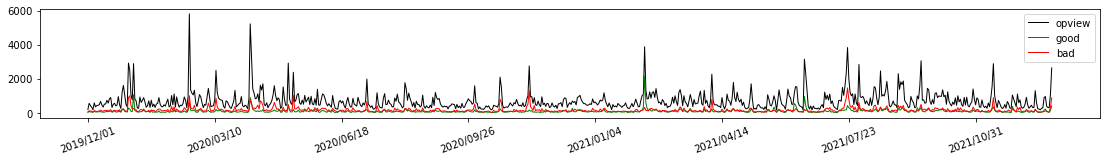

大蛇丸


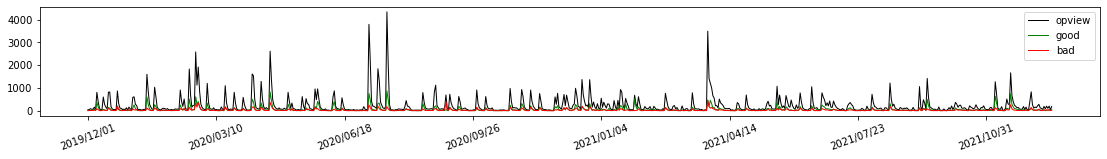

大麻煩


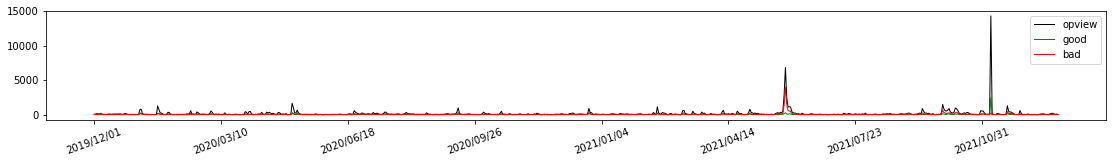

奎丁


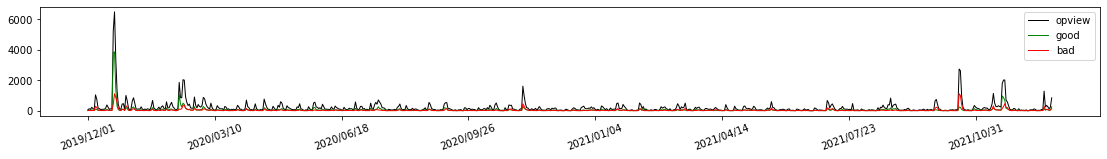

孫安佐


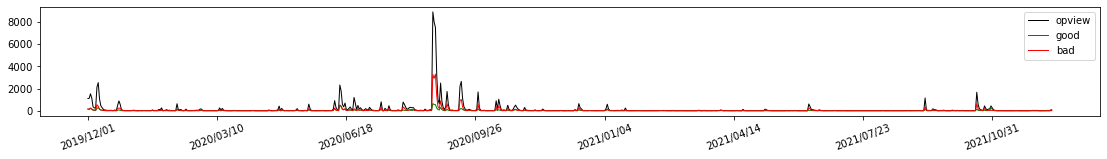

孫生


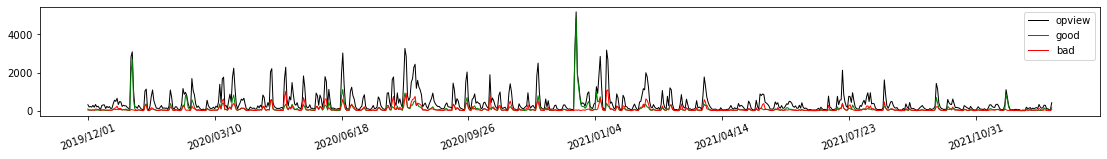

尼克


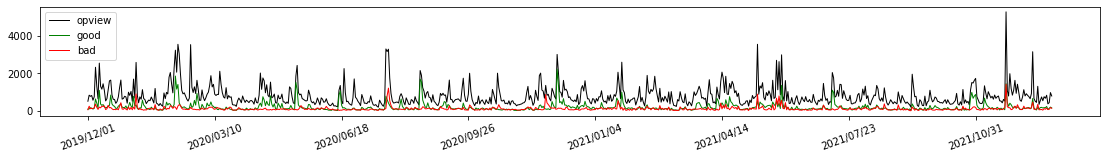

愛莉莎莎


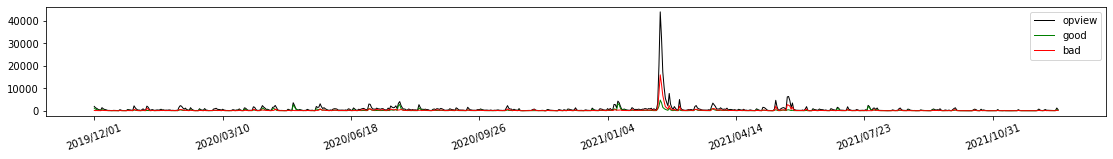

放火


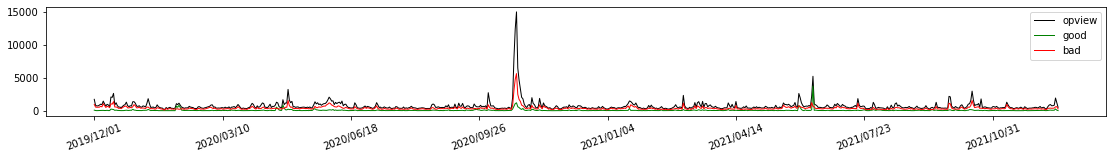

木曜4超玩


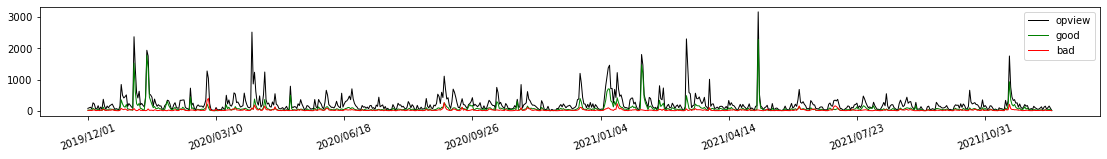

本本


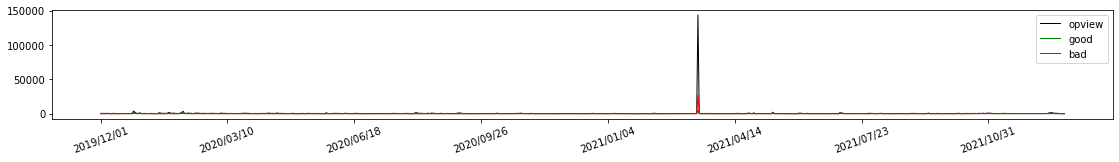

滴妹


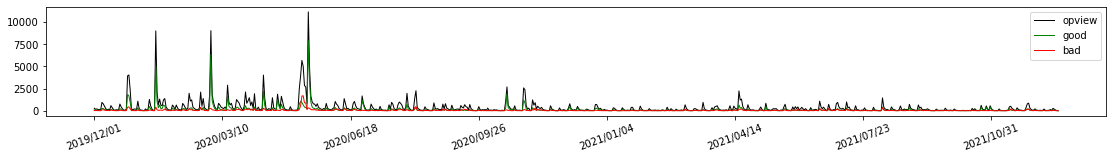

牛排生活


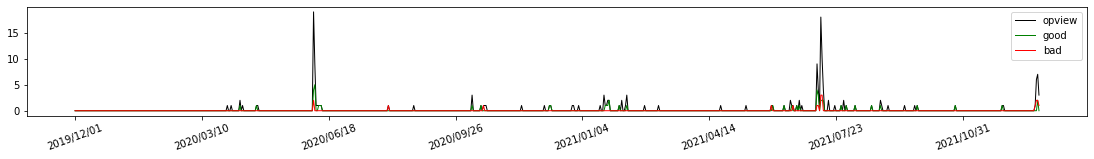

理科太太


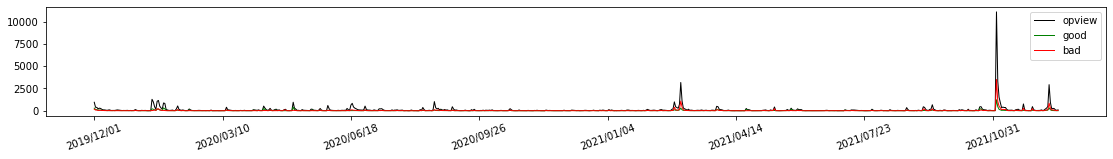

瑀熙


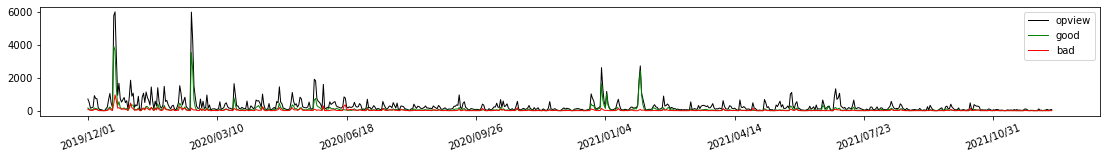

白癡公主


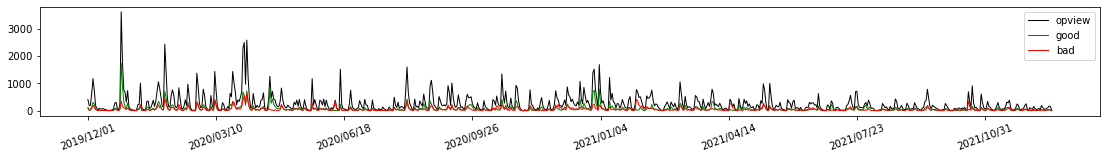

眼球中央電視台


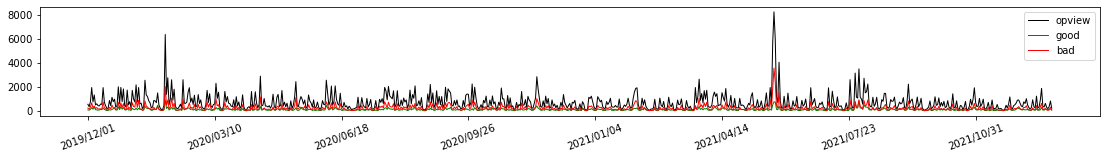

米砂


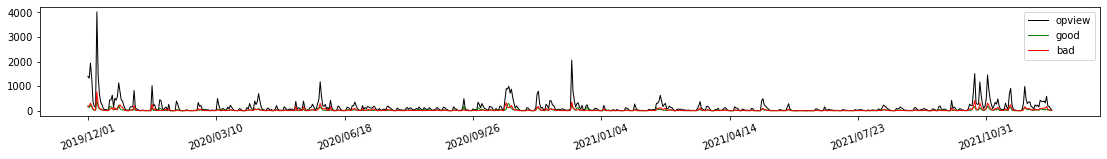

統神


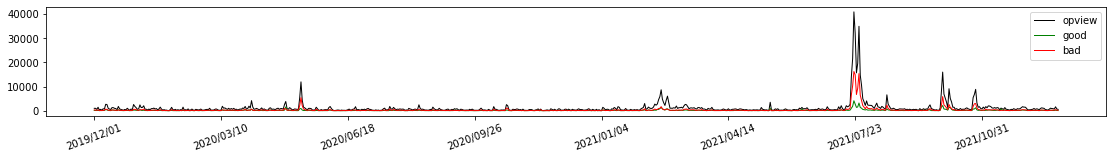

綠眼鏡Punk


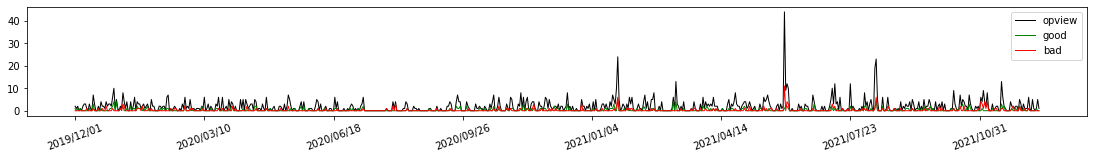

維特


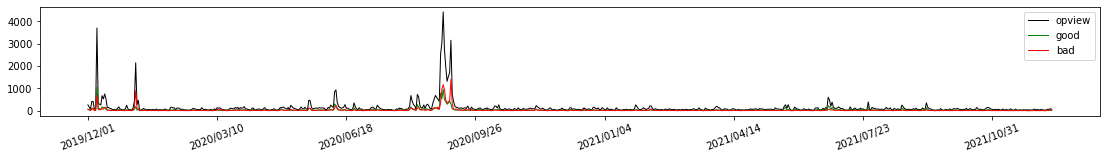

聖結石


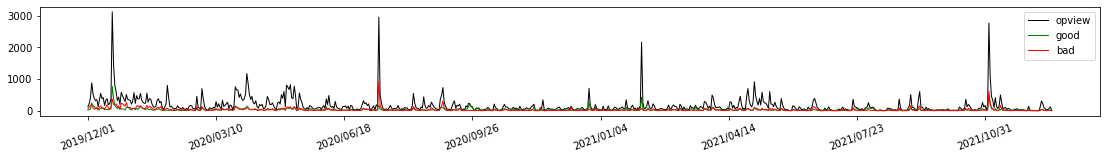

艾瑞絲


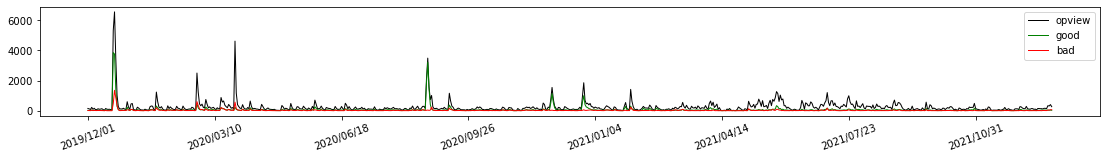

蔡桃貴


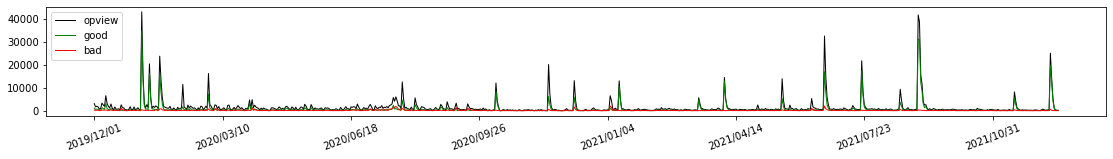

見習網美小吳


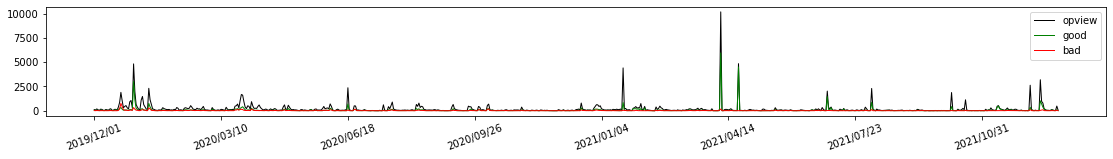

許藍方


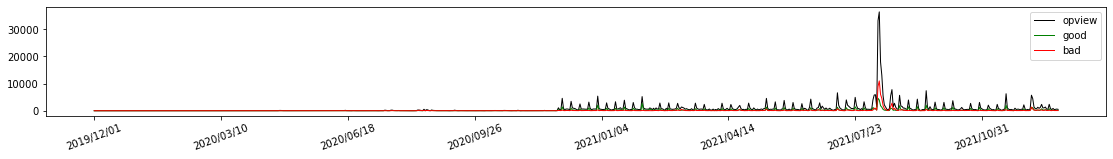

谷阿莫


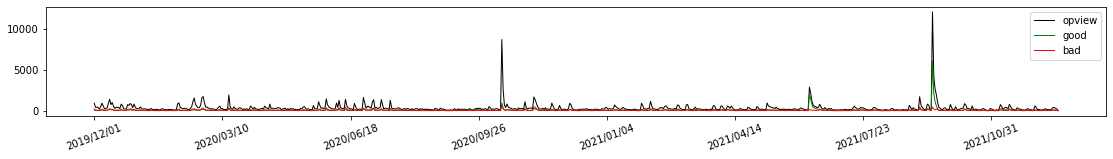

酷炫


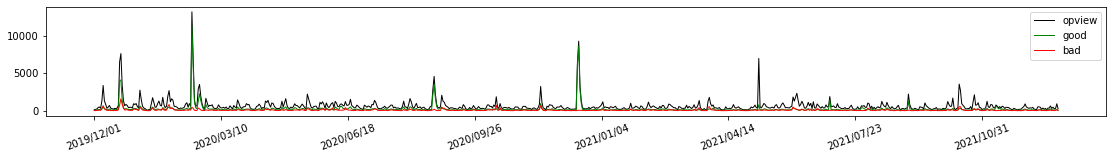

鍾明軒


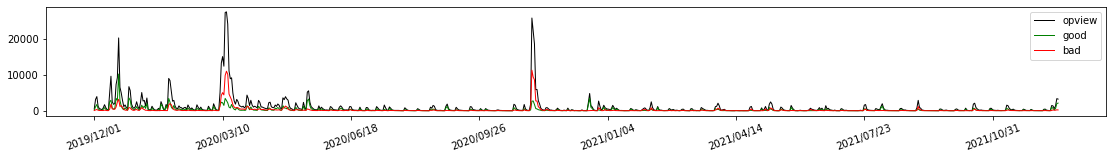

阿滴


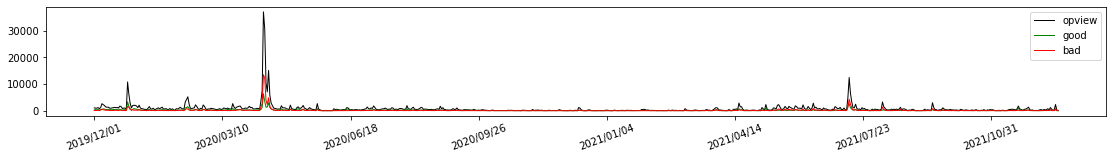

黃大謙


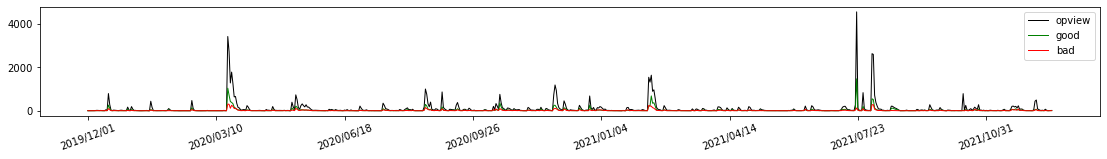

黃氏兄弟


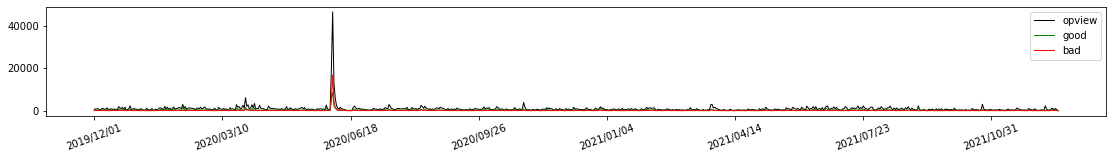

龍龍


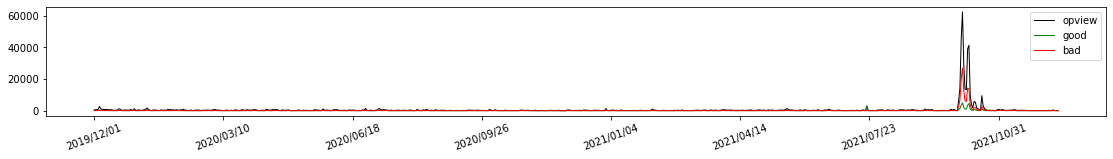

In [15]:
plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs,
                      stepsize=100, figsize=(19, 2))
